In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

data_dir = pathlib.Path('./training')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1500


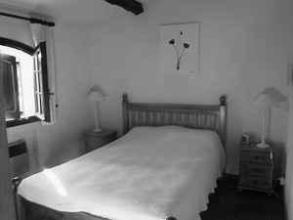

In [4]:
# Here are some bedrooms
bedrooms = list(data_dir.glob('bedroom/*'))
PIL.Image.open(str(bedrooms[1]))

In [5]:
# Load using keras.preprocessing
batch_size = 32 
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = .2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

print(train_ds.shape)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.


AttributeError: 'BatchDataset' object has no attribute 'shape'

In [119]:
# Preprocess the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=.2, 
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size=batch_size,
)

Found 1500 files belonging to 15 classes.
Using 300 files for validation.


In [120]:
class_names = train_ds.class_names
print(class_names)

['Coast', 'Forest', 'Highway', 'Insidecity', 'Mountain', 'Office', 'OpenCountry', 'Street', 'Suburb', 'TallBuilding', 'bedroom', 'industrial', 'kitchen', 'livingroom', 'store']


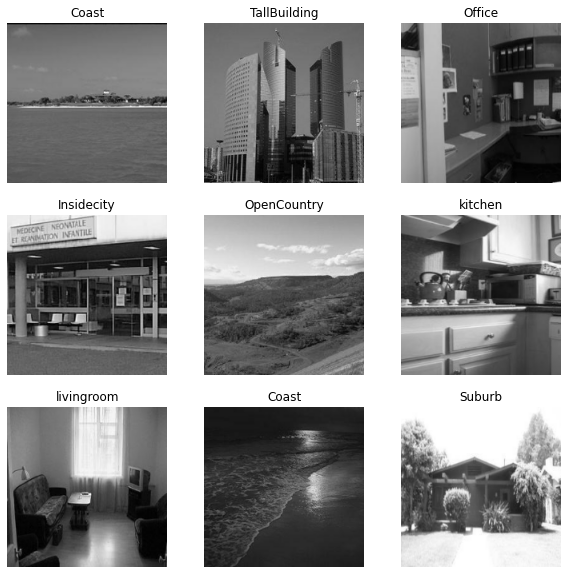

In [121]:
# Visualize the data
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [122]:
# Print shapes
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32,)


In [82]:
# Configure the dataset for performance

# Using buffered prefetching to you can yield data from disk
# without having I/O becoming blocking.

# Dataset.cache() keeps the images in memory after they're loaded
# off disk during first epoch; data won't be bottleneck during training.

# Dataset.prefetch() overlaps data preprocessing and model execution while
# training

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
# Standardize the data

# RBG channel values are in [0, 255] range -> not ideal for NN
# Standardize to [0, 1] range
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [84]:
# Technically speaking, a Python iterator object must implement 
# two special methods, __iter__() and __next__(), collectively called 
# the iterator protocol.

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.001409983 0.99403936


In [85]:
# Create the model

# The model consists of three convolution block with a max pool layer
# in each of them. Fully connected 128 units layer activated by ReLU
num_classes = 15

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [86]:
# Compile the model
model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)       

In [88]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
38/38 [==============================] - 16s 424ms/step - loss: 2.8737 - accuracy: 0.1075 - val_loss: 2.5369 - val_accuracy: 0.1700
Epoch 2/10
38/38 [==============================] - 17s 443ms/step - loss: 2.2312 - accuracy: 0.3103 - val_loss: 2.1264 - val_accuracy: 0.3467
Epoch 3/10
38/38 [==============================] - 17s 435ms/step - loss: 1.7358 - accuracy: 0.4397 - val_loss: 1.9619 - val_accuracy: 0.4100
Epoch 4/10
38/38 [==============================] - 17s 442ms/step - loss: 1.1815 - accuracy: 0.6420 - val_loss: 1.8342 - val_accuracy: 0.4667
Epoch 5/10
38/38 [==============================] - 17s 436ms/step - loss: 0.6048 - accuracy: 0.8431 - val_loss: 2.1220 - val_accuracy: 0.4333
Epoch 6/10
38/38 [==============================] - 16s 429ms/step - loss: 0.3398 - accuracy: 0.9202 - val_loss: 2.6706 - val_accuracy: 0.4000
Epoch 7/10
38/38 [==============================] - 17s 439ms/step - loss: 0.1678 - accuracy: 0.9614 - val_loss: 3.1829 - val_accuracy: 0.4067

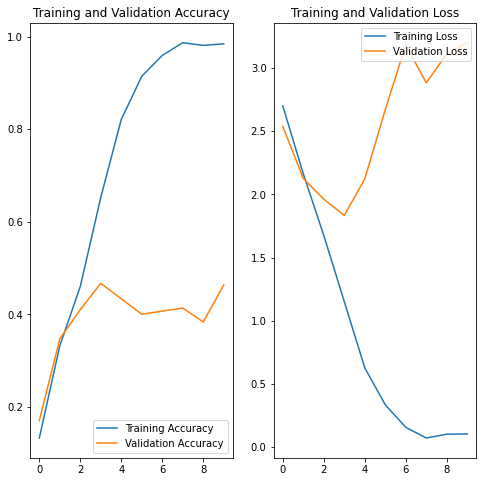

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
# Training accuracy and validation accuracy are off by large margin
# and the model  has achieved only around 40% accuracy on the validation
# set

# Let's look at what went wrong and try to increase the overall perf

In [91]:
# Solutions to fight overfitting

# Data augmentation
data_augmentation = keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                    input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(.1),
    layers.experimental.preprocessing.RandomZoom(.1)
])

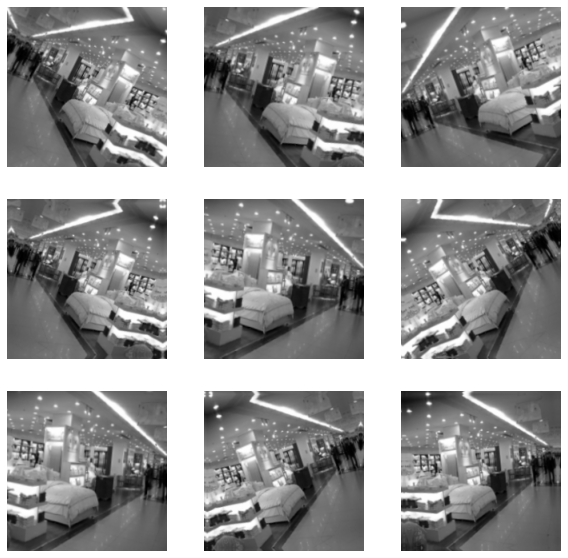

In [92]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis('off')

In [93]:
# Use dropout in the model 
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)       

In [96]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
38/38 [==============================] - 21s 514ms/step - loss: 2.9516 - accuracy: 0.0626 - val_loss: 2.6524 - val_accuracy: 0.1067
Epoch 2/15
38/38 [==============================] - 19s 488ms/step - loss: 2.6078 - accuracy: 0.1308 - val_loss: 2.4777 - val_accuracy: 0.2000
Epoch 3/15
38/38 [==============================] - 19s 487ms/step - loss: 2.3304 - accuracy: 0.2492 - val_loss: 2.4198 - val_accuracy: 0.2633
Epoch 4/15
38/38 [==============================] - 18s 477ms/step - loss: 2.1186 - accuracy: 0.3287 - val_loss: 2.4910 - val_accuracy: 0.2967
Epoch 5/15
38/38 [==============================] - 19s 494ms/step - loss: 1.9614 - accuracy: 0.3792 - val_loss: 1.9924 - val_accuracy: 0.4233
Epoch 6/15
38/38 [==============================] - 19s 490ms/step - loss: 1.9232 - accuracy: 0.3414 - val_loss: 3.5054 - val_accuracy: 0.2267
Epoch 7/15
38/38 [==============================] - 18s 480ms/step - loss: 1.9477 - accuracy: 0.3913 - val_loss: 2.1782 - val_accuracy: 0.4167

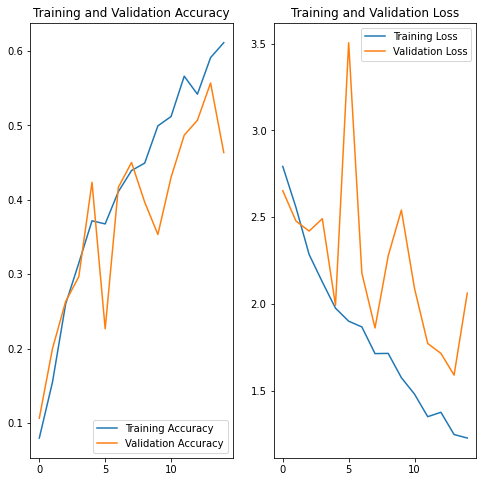

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()